# HMM and Kalman Filter

## name: Fujiwara Daigo
## student number: 6930-31-6255
## date: 2019/7/31

# 1. HMM

## 1.1 Formulation

I use "tric Dice model" as Hiden Malckov model, where there are two dices, and one of them is selected by the probability $p(x_{t+1}|x_t)$ , depending on last one. $x_t\in \{0,1\}$ is latent variable expressing which dice is used at time step $t$. $x=1$ means the tric dice is used.  There, a number of 1~6  is observed at time step $t$ as observed variable $y_t$, which depends on latent variable $x_t$. $y_t$ is obey to $p(y_t|x_t)$.

Then, now these probalities are  given as:
$$
p(x_{t+1}|x_t)=\left\{\begin{array}{ll}{1-p,} & {(x_{t+1}=x_t)} \\ {p,} & {(x_{t+1}\neq x_t)}\end{array}\right.
$$

$p(y_t|x_t)$ is bellow:

|$x_t$ \ $y_t$|1|2|3|4|5|6|
|:-|:-|:-|:-|:-|:-|:-|
|0|$\frac{1}{6}$|$\frac{1}{6}$|$\frac{1}{6}$|$\frac{1}{6}$|$\frac{1}{6}$|$\frac{1}{6}$|
|1|$\frac{1}{10}$|$\frac{1}{10}$|$\frac{1}{10}$|$\frac{1}{10}$|$\frac{1}{10}$|$\frac{1}{2}$|

We try to estimate latent variables $Z_{1:T}$, by using observed variables $X_{1:T}$ ( $T$ is ending step ).

In forward algorythm, using recursive formula about $\alpha\left(X_{t}\right)$:

$$
\begin{aligned} 
\alpha\left(X_{t}\right) & \equiv P\left(Y_{1}, \ldots, Y_{t}, X_{t}\right) \\ 
&=P\left(Y_{t} | X_{t}\right) \sum_{X_{t-1}} \alpha\left(X_{t-1}\right) P\left(X_{t} | X_{t-1}\right)
\end{aligned}
$$

In backward algorythm, using recursive formula about $\beta\left(X_{i}\right)$:

$$
\begin{aligned} 
\beta\left(X_{t}\right) & \equiv P\left(Y_{t+1}, \ldots, Y_{T} | X_{t}\right) \\ 
&=\sum_{X_{t+1}} \beta\left(X_{t+1}\right) P\left(Y_{t+1} | X_{t+1}\right) P\left(X_{t+1} | X_{t}\right) 
\end{aligned}
$$

Thus, using $\alpha\left(X_{t}\right)$ and $\beta\left(X_{i}\right)$
$$
\gamma\left(X_{t}\right) \equiv P\left(X_{t} | Y_{1}, \ldots, Y_{T}\right) \propto \alpha\left(X_{t}\right) \beta\left(X_{t}\right)
$$

And, in the estimation part, we use this probaability.

forward:
$$
P(X_t|Y_{1:t})=\frac{P(Y_{1:t},X_t)}{P(Y_{1:t})}=\frac{\alpha(X_{t})}{\sum_{X_t}\alpha(X_{t})}
$$

backward:
$$
P(X_t|Y_{t+1:T})=\frac{P(Y_{t+1:T}|X_t)P(X_t)}{P(Y_{t+1:T})}=\frac{\beta(X_{t})\cdot \frac{1}{2}}{\sum_{X_t}\beta(X_{t})\cdot \frac{1}{2}}=\frac{\beta(X_{t})}{\sum_{X_t}\beta(X_{t})}
$$

forward & backward:
$$
 P\left(X_{t} | Y_{1:T}\right)=\frac{\gamma(X_t)}{\sum_{X_t}\gamma(X_t)}
$$

## 1.2 Implementation

In [314]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal

In [2]:
class HMM:
    def __init__(self,p=0.1):
        self.p=p
            
    def makeY(self,X):
        arr=[1,2,3,4,5,6]
        res=0
        if X==0:
            res=np.random.choice(arr,1)
        else:
            res=np.random.choice(arr,1, p = [0.1,0.1, 0.1, 0.1, 0.1, 0.5])
        return int(res)
    
    def makeX(self,X):
        arr=[int(X),int(1-X)]
        res=np.random.choice(arr,1,p=[1-self.p,self.p])
        return int(res)
        
    def makeXYs(self,T,X0=0):
        Xs=np.array([])
        Ys=np.array([])
        X=X0
        Y=0
        for t in range(T):
            Xs=np.append(Xs,X)
            Y=self.makeY(X)
            Ys=np.append(Ys,Y)
            X=self.makeX(X)
        
        return Xs,Ys
    
    def Pxy(self,X,Y):
        if int(X)==0:
             return 1/6
        else:
            if int(Y)==6:
                return 0.5
            else:
                return 0.1
        
    def Pxx(self,X1,X2):
        if int(X1)==int(X2):
            return 1-self.p
        else:
            return self.p
    
    def fit(self,Ys):
        alpha=np.array([[0.5,0.5]],dtype=np.float64)
        beta=np.array([[0.5,0.5]])        

        T=Ys.shape[0]
        
        for t in range(T):
            tempa=np.zeros(2)
            tempb=np.zeros(2)
            for x in [0,1]:
                tempa[x]=self.Pxy(x,Ys[t])*(alpha[t][0]*self.Pxx(0,x)+alpha[t][1]*self.Pxx(1,x))
                tempb[x]=beta[t][0]*self.Pxy(0,Ys[T-t-1])*self.Pxx(x,0)+beta[t][1]*self.Pxy(1,Ys[T-t-1])*self.Pxx(x,1)
              
            alpha=np.append(alpha,tempa.reshape(1,2),axis=0)
            beta=np.append(beta,tempb.reshape(1,2),axis=0)

        alpha=np.delete(alpha,0,axis=0)
        beta=np.delete(beta,0,axis=0)

        beta=beta[::-1]

        self.alpha=alpha
        self.beta=beta
        s=np.sum(alpha,axis=1)
        self.pa=alpha/s.reshape(s.shape[0],1)
        s=np.sum(beta,axis=1)
        self.pb=beta/s.reshape(s.shape[0],1)
        
        gamma=alpha*beta
        s=np.sum(gamma,axis=1)
        self.pg=gamma/s.reshape(s.shape[0],1)
        self.gamma=self.pg
        
        return self.pa,self.pb,self.pg

## 1.2.1 For Given Time Series (in slides)

Now the parameter $p$ is set to $p=0.01$, though in slides it is said $p=0.1$. 
However, when $p=0.01$, the graph matches more  the slide's graph, than when $p=0.1$ it is, so I think it is just a mistake.

In [3]:
T=100
hmm=HMM(0.01)
Ys=np.array([4, 4, 5, 4, 2, 3, 3, 6, 4, 5, 5, 3, 4, 4, 1, 4, 5, 3, 6, 5,\
3, 3, 3, 5, 5, 3, 5, 6, 5, 5, 1, 3, 4, 3, 1, 2, 6, 1 ,6 ,1,5, 4, 2, 4, 1, 5, 4, 1,1 ,1 ,1, 5 ,6, 6,6, 6, 1,6, 2, 6,\
2, 6, 1, 6 ,6 ,6, 6 ,6, 3, 2, 6, 6 ,6 ,1 ,6 ,6, 2, 6, 6, 5,\
6 ,6, 5 ,6, 6, 6, 6, 4, 3, 6, 6, 5, 2, 5, 4, 5, 6, 5, 4, 4 ])

In [4]:
pa,pb,pg=hmm.fit(Ys)

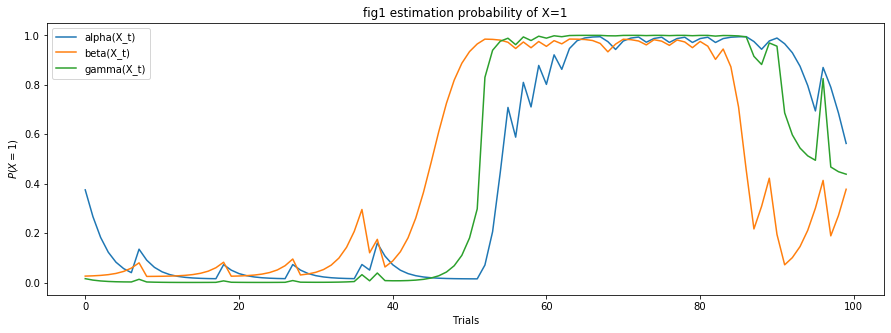

In [5]:
Ts=np.arange(T)
plt.figure(figsize=(15, 5))



plt.title("fig1 estimation probability of X=1")
#plt.plot(Ts,Xs,label="True")
plt.plot(Ts,pa.T[1],label="alpha(X_t)")
plt.plot(Ts,pb.T[1],label="beta(X_t)")
plt.plot(Ts,pg.T[1],label="gamma(X_t)")
plt.xlabel("Trials")
plt.ylabel("$P(X=1)$")
plt.legend()
plt.show()

## 1.2.2 For Time Series I Made (by this model)

I made my own time series by this model, and compare estimation with true value.

In [9]:
T1=400
Xs1,Ys1=hmm.makeXYs(T1)

(400,)

In [10]:
pa1,pb1,pg1=hmm.fit(Ys1)

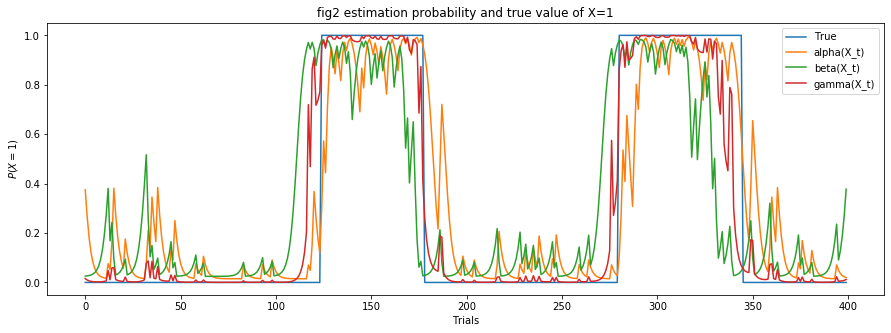

In [11]:
Ts1=np.arange(T1)
plt.figure(figsize=(15, 5))

plt.title("fig2 estimation probability and true value of X=1")
plt.plot(Ts1,Xs1,label="True")
plt.plot(Ts1,pa1.T[1],label="alpha(X_t)")
plt.plot(Ts1,pb1.T[1],label="beta(X_t)")
plt.plot(Ts1,pg1.T[1],label="gamma(X_t)")
plt.xlabel("Trials")
plt.ylabel("$P(X=1)$")
plt.legend()
plt.show()

## 1.3 Conclusion & Discussion
I can see HMM's forward algorythm, backward algorythm, and forward backward algorythm certainly estimate the latent variable. Forward backward algorythm seems to have better estimation than other two, and all of them have very sharp change at obaserved $X$ is $X=6$.
Forward algoythm tends to be late for real value, and backwardalgorythm is vise versa. Just forward backward algorythm is like mean of these two.

# 2. Kalman Filter/Smoother

## 2.1 Formulation

In the Kalman Filter, we think state space model, expressed as:

$$
\begin{aligned} \boldsymbol x_{t+1} &=A \boldsymbol x_{t}+\boldsymbol  w_{t} \\ \boldsymbol  y_{t} &=C\boldsymbol  x_{t}+\boldsymbol v_{t} \\ \boldsymbol  w_{t} & \sim N(0, \Gamma) \\ \boldsymbol  v_{t} & \sim N(0, \Sigma) \end{aligned}
$$

where,$\boldsymbol x_t$ is state varable (latent variable), and $\boldsymbol y_t$ is observed variable.

These can be written as probabilistic model, like bellow:

$$
p\left(\boldsymbol x_{t+1} |\boldsymbol  x_{t}, \theta\right)=N\left(\boldsymbol x_{t+1} ; A\boldsymbol  x_{t}, \Gamma\right)
$$
$$
p\left(\boldsymbol y_{t} |\boldsymbol  x_{t}, \theta\right)=N\left(\boldsymbol y_{t} ; C\boldsymbol  x_{t}, \Sigma\right)
$$
$$
p\left(\boldsymbol x_{1}\right)=N\left(\boldsymbol x_{1} ; 0, \Gamma_{0}\right)
$$
$$
\theta=\left\{A, C, \Gamma, \Sigma, \Gamma_{0}\right\}
$$

In Kalman filter, we estimate $\hat{\alpha}\left(\boldsymbol x_{t}\right)=p\left(\boldsymbol x_{t} | \boldsymbol y_{1 : t}\right)$.
By the dynamics, $\hat{\alpha}\left(\boldsymbol x_{t}\right)$ also obey to Gaussian distribution, so can be written as:
$$
\hat{\alpha}\left(\boldsymbol x_{t}\right)=N\left(\boldsymbol x_{t} ;\boldsymbol  \mu_{t}, V_{t}\right)
$$

$\hat{\alpha}\left(\boldsymbol x_{t}\right)$ fills recursive formula similar to forward algorythm of HMM. It is:

$$
\begin{aligned} \hat{\alpha}\left(x_{t}\right) & \equiv p\left(x_{t} | y_{1: t}\right)=p\left(y_{t} | x_{t}\right) p\left(y_{1: t-1}, x_{t}\right) / p\left(y_{1: t}\right) \\ &=\frac{p\left(y_{t} | x_{t}\right)}{p\left(y_{t}\right)} \int p\left(x_{t-1} | y_{1: t-1}\right) p\left(x_{t} | x_{t-1}\right) d x_{t-1} \\ &=\frac{p\left(y_{t} | x_{t}\right)}{p\left(y_{t}\right)} \int \hat{\alpha}\left(x_{t-1}\right) p\left(x_{t} | x_{t-1}\right) d x_{t-1} \end{aligned}
$$

Substituting each distribution, and calculating the parameters, we can get the relation between parameters,

$$
\begin{aligned}c_t N\left(x_{t} ; \mu_{t}, V_{t}\right) &=N\left(y_{t} ; C x_{t}, \Sigma\right) \int N\left(x_{t-1} ; \mu_{t-1}, V_{t-1}\right) N\left(x_{t} ; A x_{t-1}, \Gamma\right) d x_{t-1} \\ &=N\left(y_{t} ; C x_{t}, \Sigma\right) N\left(x_{t} ; A \mu_{t-1}, P_{t-1}\right) \end{aligned}
$$

Thus,

$$
\mu_{t}=A \mu_{t-1}+K_{t}\left(y_{t}-C A \mu_{t-1}\right)
$$
$$
P_{t-1}=A V_{t-1} A^{T}+\Gamma
$$
$$
V_{t}=\left(I-K_{t} C\right) P_{t-1}
$$
$$
K_{t}=P_{t-1} C^{T}\left(C P_{t-1} C^{T}+\Sigma\right)^{-1}
$$

In the Kalman Smother,  we estimate $\hat{\gamma}\left(x_{t}\right)=p\left(x_{t} | y_{1 : T}\right)$. Like HMM forward backward algorythm, we use $\hat{\beta}\left(x_{t}\right)=p\left(x_{t} | y_{t+1 : T}\right)$ from backward and get $\hat{\gamma}\left(x_{t}\right)$ by the fomula of :
$$
\hat{\gamma}\left(x_{t}\right) \propto \hat{\alpha}\left(x_{t}\right) \hat{\beta}\left(x_{t}\right)
$$

$\hat{\beta}\left(x_{t}\right)$ fills recursive formula similar to backward algorythm of HMM. It is:

$$
c_{t+1} \hat{\beta}\left(x_{t}\right)=\int \hat{\beta}\left(x_{t+1}\right) p\left(x_{t+1} | y_{t+1}\right) p\left(x_{t+1} | x_{t}\right) d x_{t+1}
$$

$\hat{\gamma}\left(x_{t}\right)$ also obey to Gaussian distribution, and parameters relation is:

$$
\hat{\gamma}\left(x_{t}\right) \propto \hat{\alpha}\left(x_{t}\right) \hat{\beta}\left(x_{t}\right)=N\left(x_{t} ; \hat{\mu}_{t}, \hat{V}_{t}\right)
$$

Then,

$$
J_{t}=V_{t} A^{T}\left(P_{t}\right)^{-1}
$$
$$
\hat{\mu}_{t}=\mu_{t}+J_{t}\left(\hat{\mu}_{t+1}-A \mu_{t}\right)
$$
$$
\hat{V}_{t}=V_{t}+J_{t}\left(\hat{V}_{t+1}-P_{t}\right) J_{t}^{T}
$$

Now we use as parameters:
$$
\theta=\left\{A=1, C=1, \Gamma=1, \Sigma =100, \Gamma_{0}=1\right\}
$$

## 2.2 Implementation

In [354]:
class Kalman:
    def __init__(self,A=1,C=1,Gamma=1,Sigma=1,Gamma0=1,D=1,d=1):
        self.A=np.array(A).reshape(D,D)
        self.C=np.array(C).reshape(d,D)
        self.D=D
        self.d=d
        self.Gamma=np.array(Gamma).reshape(D,D)
        self.Sigma=np.array(Sigma).reshape(d,d)
        self.Gamma0=np.array(Gamma0).reshape(D,D)
        self.X0=multivariate_normal.rvs(mean=np.zeros(D), cov=self.Gamma0)
            
    def makeY(self,X):
        res=0
        res=multivariate_normal.rvs(mean=np.dot(self.C,X), cov=self.Sigma)
        return res
    
    def makeX(self,X):
        res=0
        res=multivariate_normal.rvs(mean=np.dot(self.A,X), cov=self.Gamma)
        return res
        
    def makeXYs(self,T):
        Xs=[]
        Ys=[]
        X=self.X0
        Y=0
        for t in range(T):
            Xs.append(X)
            Y=self.makeY(X)
            Ys.append(Y)
            X=self.makeX(X)
            
        Xs=np.array(Xs)
        Ys=np.array(Ys)
        
        return Xs,Ys
    
    def fit(self,Ys,mu0,V0):
        mu=np.array(mu0).reshape(self.D)
        V=np.array(V0).reshape(self.D,self.D)
        mus=[]
        Vs=[]
        T=Ys.shape[0]
        
        for t in range(T):
            mus.append(mu)
            Vs.append(V)
            if np.isnan(Ys[t]):
                mu=np.dot(self.A,mu)
                V=np.dot(np.dot(self.A,V),self.A.T)+self.Gamma
            else:
                tmp=np.dot(self.A,mu)
                P=np.dot(np.dot(self.A,V),self.A.T)+self.Gamma
                inv=np.linalg.inv(np.dot(np.dot(self.C,P),self.C.T)+self.Sigma)
                K=np.dot(np.dot(P,self.C.T),inv)
                mu=tmp+np.dot(K,Ys[t]-np.dot(self.C,tmp))
                V=np.dot(np.eye(self.D)-np.dot(K,self.C),P)
         
        mus.append(mu)
        Vs.append(V)

        mus=np.array(mus)
        Vs=np.array(Vs)

        mus=np.delete(mus,0)
        Vs=np.delete(Vs,0)
        
        mus=np.array(mus)
        Vs=np.array(Vs)

        mu_=mu
        V_=V
        mu_s=[]
        V_s=[]
        
        for t in range(T-1):
            mu_s.append(mu_)
            V_s.append(V_)
            P=np.dot(np.dot(self.A,Vs[T-t-2]),self.A.T)+self.Gamma
            J=np.dot(np.dot(Vs[T-t-2],self.A.T),np.linalg.inv(P))
            tmps=mu_-np.dot(self.A,mus[T-t-2])
            mu_=mus[T-t-2]+np.dot(J,tmps)
            V_=Vs[T-t-2]+np.dot(np.dot(J,V_-P),J.T)
        
        mu_s.append(mu_)
        V_s.append(V_)
        
        mu_s.reverse()
        V_s.reverse()
        
        mu_s=np.array(mu_s)
        V_s=np.array(V_s)
        

        
        self.amu=mus.reshape(mus.shape[0])
        self.aV=Vs.reshape(Vs.shape[0])
        
        alpha=np.array([self.amu,self.aV],dtype=np.float64)
        
        self.gmu=mu_s.reshape(mu_s.shape[0])
        self.gV=V_s.reshape(V_s.shape[0])
        
        gamma=np.array([self.gmu,self.gV],dtype=np.float64)
        
        return alpha,gamma

## 2.2.1 Kalman Filter

I used Kalman filter for the time series of that model, and masking the range of $t=200\sim 400$, estimate missing value with probabilistic variance. 

In [382]:
kl=Kalman(A=1,C=1,Gamma=1,Sigma=100,Gamma0=1,D=1,d=1)
T2=500
Xs2,Ys2=kl.makeXYs(T2)

In [356]:
Ymasked=Ys2.copy()
Ymasked[200:400]=np.nan

In [357]:
alpha2,gamma2=kl.fit(Ymasked,0,1)

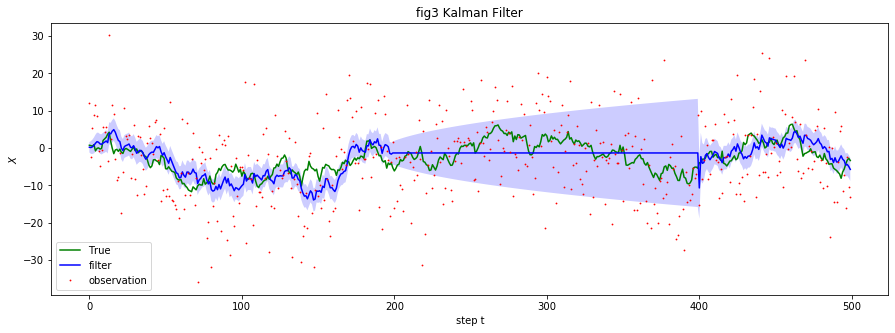

In [381]:
Ts2=np.arange(T2)
plt.figure(figsize=(15, 5))

plt.title("fig3 Kalman Filter")
plt.plot(Ts2,Xs2,label="True",color="g")
plt.plot(Ts2,alpha2[0],label="filter",color="b")
plt.plot(Ts2,Ys2,"o",ms=0.8,label="observation",color="r")
z1=-1*np.sqrt(alpha2[1])+alpha2[0]
z2=np.sqrt(alpha2[1])+alpha2[0]
plt.fill_between(Ts2,z1,z2,where=z1<z2,facecolor='b',alpha=0.2)
plt.xlabel("step t")
plt.ylabel("$X$")
plt.legend()
plt.show()

## 2.2.2 Kalman Smoother

As well as Kalman filter, I used Kalman smoother for the time series of that model, and masking the range of $t=200\sim 400$, estimate missing value with probabilistic variance. 

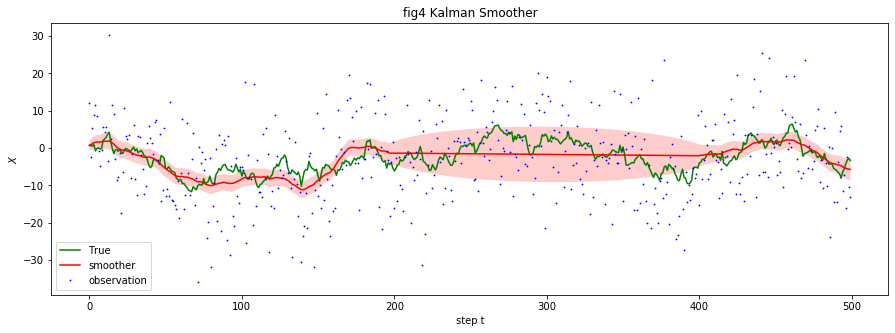

In [380]:
Ts2=np.arange(T2)
plt.figure(figsize=(15, 5))

plt.title("fig4 Kalman Smoother")
plt.plot(Ts2,Xs2,label="True",color="g")
plt.plot(Ts2,gamma2[0],label="smoother",color="r")
plt.plot(Ts2,Ys2,"o",ms=0.8,label="observation",color="b")
z1=-1*np.sqrt(gamma2[1])+gamma2[0]
z2=np.sqrt(gamma2[1])+gamma2[0]
plt.fill_between(Ts2,z1,z2,where=z1<z2,facecolor='r',alpha=0.2)
plt.xlabel("step t")
plt.ylabel("$X$")
plt.legend()
plt.show()

## 2.3 Conclusion & Discussion
I can see Kalman filter and smoother can estimate latent state variable well, and can estimate also the probability of the area, and estimation. Kalman filter is changing less smoothly, but reflects real value's change　more. Kalman smoother is vice versa. By using back ward estimation, Kalman smoother can surppress the variance's increase oposite side. Kalman filter can't do that, but it can be used in on-line use for exanmple Robot sensing. Finally, it is so surprising that Kalman filter/smoother can get such a close estimation from these very scattered and noisy observation.